# Notes:

1. Extract data from Port Buffer (Do not re-run)
2. Create Routes p1
3. Create Routes p2 and Validate Vessel Information
4. <b>Update Departures Draught Info</b>
5. Extract to Local
6. Trade Estimation (Local)

Set-up: UNGP - kernel `ais-tt-dev`

For each route, we get the next port visited using the following:

1. get list of imo x mmsi from Port Calls
2. For each vessel, get only the AIS messages that are in between consecutive port calls in the Pacific Islands
3. flag Speed Over Ground (SOG) < 1 to know when the ships stops
4. match with imf Port Boundaries to capture stop within ports.
5. create routes dataset by aggregating by ship stop, polygon routes

Since this will consume a lot of resources, we will use the Global Movements Dataset prepared by ADB instead of the raw AIS data. The Global Movements Dataset (GMD) is the AIS data aggregated by "mpvements" based on whether the ship is stopped or not, within Port Buffer or not, and within Trading passageways (e.g. Suez Canal) or not. The GMD is significantly smaller in size compared to the raw AIS data (+90% reduction in rows) and contains the important information needed to define port calls. However, it is still in its early stages and is subject to revision. The final methodology for the dataset will be part of the supplement to the 2023 Key Indicators for Asia and Pacific publication.  

Warning: Notebook will consume a lot of resources

# Initializers

In [1]:
from ais import functions as af

In [2]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import LongType

import h3.api.numpy_int as h3int

In [3]:
import pandas as pd
import geopandas as gpd

import json

In [4]:
from shapely.geometry import mapping

In [5]:
pd.set_option("display.max_columns", None)  # Show all columns in pandas df
pd.set_option("display.max_rows", 200)  # Show 100 rows in pandas df
pd.options.display.float_format = (
    "{:,}".format
)  # Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import (
    InteractiveShell,
)  # allow multiple outputs in one jupyter cell

InteractiveShell.ast_node_interactivity = "all"

## Variables

In [6]:
basepath = "s3a://ungp-ais-data-historical-backup/user_temp/"

# all outputs are saved here. when creating your own please change path
# path = f"{basepath}worldbank/"

s3path = "s3a://ungp-ais-data-historical-backup/user_temp/"
wb_path = f"{s3path}worldbank/"
path_lbn = f"{wb_path}syria/"
path_port_calls = f"{wb_path}syria_port_calls/"

portcall_path_next = f"{wb_path}syria_port_calls_next/"

In [7]:
adb_path = f"{basepath}/adb/"

global_routes_path = f"{adb_path}ki/global_routes_all/"

# Data

## Port Calls

In [105]:
path_port_calls

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/syria_port_calls/'

In [106]:
port_calls = pd.read_pickle(f"{path_port_calls}port_calls_10142024.pkl")

In [107]:
len(port_calls)

1516

In [108]:
# port_calls = pd.concat([pd.read_pickle(f"{portcall_path}{country}/{year}.pkl") for year in range(2019,2024) for country in country_list], ignore_index=True)
# port_calls.info()
# port_calls.head()

## Port Boundaries

In [109]:
# token = "Zskmd5kwe7QywgjWfNTE"
# project_id = 358
# file_path = "data/AIS_Jasper/port_boundaries.geojson"

# string = af.get_file_gitlab(
#     token,
#     project_id,
#     file_path,
#     org_path="https://code.officialstatistics.org",
#     branch="main",
#     csv_df=False,
# )

# imf = (
#     gpd.GeoDataFrame.from_features(json.loads(string))
#     .drop_duplicates()
#     .rename(columns={"geometry": "port_boundary"})
#     .set_geometry("port_boundary")
# )
# imf.info()
# imf.head()

In [110]:
s3path = "s3a://ungp-ais-data-historical-backup/user_temp/"
wb_path = f"{s3path}worldbank/"
imf = pd.read_pickle(wb_path + "imf_port_boundary.pkl") \
            .set_crs(crs="epsg:4326") \
            .rename(columns={'geometry':'port_boundary'}) \
            .set_geometry('port_boundary')

Fix duplicates

Vietnam_Nghe Tinh


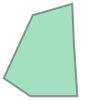

0.022823183564871927

In [111]:
for i in range(1):
    chosen = imf[imf[["Port_name", "Country"]].duplicated(keep=False)]
    print(f"{chosen['Country'].iloc[i]}_{chosen['Port_name'].iloc[i]}")
    chosen.port_boundary.iloc[i]
    chosen.port_boundary.iloc[i].area

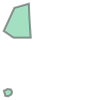

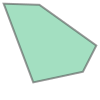

In [112]:
# separate areas same name - get bigger
temp = imf.dissolve(by=["Continent", "Port_name", "Country"]).reset_index()
temp[(temp["Country"] == "Vietnam") & (temp["Port_name"] == "Nghe Tinh")].iloc[
    0
].port_boundary

# same area,  get bigger
temp = imf.dissolve(by=["Continent", "Port_name", "Country"]).reset_index()
temp[(temp["Country"] == "Papua New Guinea") & (temp["Port_name"] == "Lae")].iloc[
    0
].port_boundary

In [113]:
imf = imf.drop_duplicates(subset=["Country", "Port_name"], keep="first")

# Prep Data

In [114]:
port_calls.head(2)

,mmsi,imo,vessel_name,new_route_group,Port,length,width,vessel_type,arrival_dt_pos_utc,arrival_draught,arrival_destination,count_ais,max_sog,min_sog,departure_dt_pos_utc,departure_draught,departure_destination,mean_sog,time_spent,prev_departure_dt_pos_utc,time_travel,year,month,date,StatCode5,ShipName,ExName,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate
0,"209,279,000.0","9,232,163.0",EVNIA,1.0,Al Ladhiqiyah,190.0,32.0,Cargo,2021-10-10 18:24:50,7.6,AL LADHIQIYAH,403.0,7.2,0.0,2021-10-17 01:46:39,7.6,AL LADHIQIYAH,0.1,6 days 07:21:49,NaT,NaT,2021,10,2021-10-10,A21A2BC,EVNIA,NaN,"31,167.0","53,806.0",189.99,0.0,0.0,32.294,32.26,"63,707.0",12.49,"9,901.0","17,600.0",Bulk Carrier,Bulk Carrier,Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Bulk Carrier,imo x mmsi,"9,232,163.0",EVNIA,2022-12-31,NaN,okay - match ship name,0.0,1.0,0.0
1,"210,468,000.0","9,364,849.0",SERENITY IBTIHAJ,1.0,Al Ladhiqiyah,170.0,27.0,Cargo,2022-07-22 08:34:56,7.3,LATTAKIA,585.0,77.5,0.0,2022-08-02 11:22:25,7.3,LATTAKIA,0.30940170940170914,11 days 02:47:29,NaT,NaT,2022,7,2022-07-22,A21A2BC,LADY NANA,Serenity Ibtihaj,"16,951.0","28,399.0",169.3,161.21,0.0,27.237,27.2,"34,766.0",9.8,"6,367.0","10,134.0",Bulk Carrier,Bulk Carrier,Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Bulk Carrier,imo,"9,364,849.0",Serenity Ibtihaj,2024-06-01,"352,004,134.0",okay - match ship name,0.8125,0.0,0.0


In [115]:
port_calls.loc[:, "Country"] = "Syria"

In [116]:
# port calls
port_calls = (
    port_calls.reset_index()
    .sort_values(["mmsi", "imo", "departure_dt_pos_utc"])[
        [
            "mmsi",
            "imo",
            "arrival_dt_pos_utc",
            "departure_dt_pos_utc",
            "Country",
            "Port",
            "index",
        ]
    ]
    .rename(
        columns={
            "mmsi": "pc_mmsi",
            "imo": "pc_imo",
            "Country": "pc_country",
            "Port": "pc_port",
            "arrival_dt_pos_utc": "pc_arrival_dt",
            "departure_dt_pos_utc": "pc_departure_dt",
            "index": "pc_unique_no",
        }
    )
)
port_calls["pc_next_arrival_dt"] = (
    port_calls.groupby(["pc_mmsi", "pc_imo"])["pc_arrival_dt"]
    .shift(-1)
    .fillna(pd.to_datetime("2023-05-01"))
)

port_calls.head()

,pc_mmsi,pc_imo,pc_arrival_dt,pc_departure_dt,pc_country,pc_port,pc_unique_no,pc_next_arrival_dt
0,"209,279,000.0","9,232,163.0",2021-10-10 18:24:50,2021-10-17 01:46:39,Syria,Al Ladhiqiyah,0,2023-05-01 00:00:00
1,"210,468,000.0","9,364,849.0",2022-07-22 08:34:56,2022-08-02 11:22:25,Syria,Al Ladhiqiyah,1,2023-05-01 00:00:00
2,"210,698,000.0","9,232,151.0",2022-03-08 04:39:35,2022-03-12 18:10:41,Syria,Al Ladhiqiyah,2,2023-05-01 00:00:00
3,"211,182,720.0","9,155,365.0",2019-11-20 11:59:45,2019-11-21 18:11:49,Syria,Al Ladhiqiyah,3,2020-01-09 00:02:59
4,"211,182,720.0","9,155,365.0",2020-01-09 00:02:59,2020-01-09 23:11:14,Syria,Al Ladhiqiyah,4,2023-05-01 00:00:00


In [117]:
port_calls["pc_next_arrival_dt"] - port_calls["pc_arrival_dt"]

0        567 days 05:35:10
1        282 days 15:25:04
2        418 days 19:20:25
3         49 days 12:03:14
4       1207 days 23:57:01
               ...        
1511     162 days 01:09:28
1512   -173 days +11:02:20
1513     851 days 00:22:31
1514     606 days 19:42:25
1515     668 days 06:52:04
Length: 1516, dtype: timedelta64[ns]

In [118]:
# unique identifier for port calls
port_calls.pc_unique_no.nunique()
port_calls.shape

1516

(1516, 8)

In [26]:
# Spark Dataframe
route_sdf = spark.createDataFrame(port_calls)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [27]:
# route_sdf.count()
# route_sdf.printSchema()

In [28]:
# Port boundaries
# We choose resolution 10 because some polygons are too small to be fitted a lower resolution.
query_polys = [
    (
        f"{imf.Country.iloc[i]}:{imf.Port_name.iloc[i]}",
        mapping(imf.port_boundary.iloc[i]),
    )
    for i in range(imf.shape[0])
]
len(query_polys)

query_polys[0]

1593

('U.S.A.:Anchorage',
 {'type': 'Polygon',
  'coordinates': (((-149.9321447362291, 61.258287735699795),
    (-149.8390591326616, 61.2586723869542),
    (-149.84713680900424, 61.20020539628371),
    (-149.93829915629968, 61.19828214001165),
    (-149.9321447362291, 61.258287735699795)),)})

In [29]:
imf_df_hex = (
    af.polygon_to_hex_df(query_polys, hex_resolution=10, overfill=False)
    .rename(columns={"hex_id": "H3_int_index_10", "polygon_name": "imf_boundary"})
    .drop(columns="hex_resolution")
)
imf_df_hex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312825 entries, 0 to 6312824
Data columns (total 2 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   H3_int_index_10  int64 
 1   imf_boundary     object
dtypes: int64(1), object(1)
memory usage: 96.3+ MB


In [30]:
imf_df_hex[["Country", "Port"]] = imf_df_hex["imf_boundary"].str.split(":", expand=True)

In [31]:
imf_df_hex[imf_df_hex.H3_int_index_10.duplicated(keep=False)]  # no duplicate h3

,H3_int_index_10,imf_boundary,Country,Port


In [32]:
imf_df_hex

,H3_int_index_10,imf_boundary,Country,Port
0,621715773121921023,U.S.A.:Anchorage,U.S.A.,Anchorage
1,621715773474242559,U.S.A.:Anchorage,U.S.A.,Anchorage
2,621715773155475455,U.S.A.:Anchorage,U.S.A.,Anchorage
3,621715773230972927,U.S.A.:Anchorage,U.S.A.,Anchorage
4,621715759079391231,U.S.A.:Anchorage,U.S.A.,Anchorage
...,...,...,...,...
6312820,622642287562686463,China:Guangzhou,China,Guangzhou
6312821,622642179456991231,China:Guangzhou,China,Guangzhou
6312822,622642292025425919,China:Guangzhou,China,Guangzhou
6312823,622642288133111807,China:Guangzhou,China,Guangzhou


In [ ]:
imf_sdf_hex = spark.createDataFrame(imf_df_hex)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


# Process

## Test 1 year using global movements

In [34]:
geo_to_h3 = F.udf(lambda lat, lon: h3int.geo_to_h3(lat, lon, 10), LongType())

In [36]:
# # stopped at least one hour
# # count without at least one hour: 220291921
# sdf = (
#     spark.read.parquet(global_routes_path + "year=2019")
#     .withColumn(
#         "time_hour",
#         (
#             F.col("departure_dt_pos_utc").cast("long")
#             - F.col("arrival_dt_pos_utc").cast("long")
#         )
#         / 3600,
#     )
#     .filter((F.col("stopped") == 1) & (F.col("time_hour") > 1))
#     .withColumn("H3_int_index_10", geo_to_h3(F.col("latitude"), F.col("longitude")))
# )
# sdf.count()

In [28]:
sdf2 = (
    sdf.join(
        F.broadcast(route_sdf),
        on=(
            (sdf.mmsi == route_sdf.pc_mmsi)
            & (sdf.imo == route_sdf.pc_imo)
            & (
                sdf["arrival_dt_pos_utc"].between(
                    route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt
                )
            )
        ),
        how="inner",
    )
    .join(imf_sdf_hex, on="H3_int_index_10", how="inner")
    .drop("pc_mmsi", "pc_imo")
)
sdf2.count()
# sdf2.show(n=10)
# 27524

28389

In [29]:
sdf3 = sdf2.groupBy("pc_unique_no").agg(
    F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
    F.min_by("arrival_draught", "arrival_dt_pos_utc").alias("arrival_draught"),
    F.min_by("Country", "arrival_dt_pos_utc").alias("Country"),
    F.min_by("Port", "arrival_dt_pos_utc").alias("Port"),
    F.collect_set(F.col("Country")).alias("country_list"),
)
sdf3.cache()

DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

In [30]:
sdf3.cache()
sdf3.count()

DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

3118

In [31]:
sdf3.show()

+------------+-------------------+---------------+----------------+----------------+--------------------+
|pc_unique_no| arrival_dt_pos_utc|arrival_draught|         Country|            Port|        country_list|
+------------+-------------------+---------------+----------------+----------------+--------------------+
|       14719|2019-03-15 16:51:40|           10.4|          Taiwan|      Kao Hsiung|[South Korea, Phi...|
|       13098|2019-02-15 04:33:21|            5.8|          U.S.A.|        Honolulu|[French Polynesia...|
|       11745|2019-04-17 05:24:57|            7.4|      Bangladesh|      Chittagong|[Myanmar, Indones...|
|        4823|2019-12-16 20:58:11|            6.0|       Australia|          Darwin|[Australia, Indon...|
|       13248|2019-02-15 00:53:14|            6.1|       Australia|       Melbourne|[Australia, New C...|
|        5556|2019-06-21 14:08:36|            4.0|Papua New Guinea|             Lae|  [Papua New Guinea]|
|       11190|2019-11-24 00:12:42|            

In [32]:
next_pc = sdf3.toPandas()
sdf3.unpersist()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

In [33]:
port_calls.merge(next_pc).to_pickle(portcall_path_next + "2019.pkl")

In [34]:
next_df = port_calls.merge(next_pc)

In [35]:
temp = (
    sdf2.filter(F.col("pc_imo") == 8977285)
    .select(
        "imo",
        "mmsi",
        "arrival_dt_pos_utc",
        "Country",
        "Port",
        "pc_unique_no",
        "pc_next_arrival_dt",
        "pc_departure_dt",
    )
    .toPandas()
)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [36]:
temp.sort_values("arrival_dt_pos_utc")

,imo,mmsi,arrival_dt_pos_utc,Country,Port,pc_unique_no,pc_next_arrival_dt,pc_departure_dt
0,8977285,205388000,2019-05-02 22:49:11,Singapore,Singapore,10511,2019-07-01 23:24:35,2019-01-10 00:28:40
1,8977285,205388000,2019-05-02 22:49:11,Singapore,Singapore,10511,2019-07-01 23:24:35,2019-01-10 00:28:40
2,8977285,205388000,2019-05-03 03:11:00,Singapore,Singapore,10511,2019-07-01 23:24:35,2019-01-10 00:28:40
3,8977285,205388000,2019-05-03 03:11:00,Singapore,Singapore,10511,2019-07-01 23:24:35,2019-01-10 00:28:40


In [37]:
next_df

,pc_mmsi,pc_imo,pc_arrival_dt,pc_departure_dt,pc_country,pc_port,pc_unique_no,pc_next_arrival_dt,arrival_dt_pos_utc,arrival_draught,Country,Port,country_list
0,205388000,8977285,2019-01-04 11:18:38,2019-01-10 00:28:40,Palau,Malakal Harbor,10511,2019-07-01 23:24:35,2019-05-02 22:49:11,2.7,Singapore,Singapore,[Singapore]
1,209594000,9435533,2019-08-21 04:21:39,2019-08-22 09:23:34,Papua New Guinea,Lae,3078,2019-08-24 00:44:27,2019-08-24 00:44:27,7.1,Papua New Guinea,Wewak Harbor,[Papua New Guinea]
2,209594000,9435533,2019-09-30 20:35:04,2019-10-02 21:25:50,Papua New Guinea,Wewak Harbor,3097,2019-10-23 20:01:37,2019-10-11 20:43:39,6.8,Malaysia,Tanjung Pelepas,[Malaysia]
3,209594000,9435533,2019-11-05 20:22:00,2019-11-06 22:32:21,Papua New Guinea,Wewak Harbor,3098,2019-11-29 01:30:13,2019-11-17 02:10:08,7.4,Malaysia,Tanjung Pelepas,[Malaysia]
4,211627240,9633927,2019-01-25 18:59:20,2019-01-28 05:18:21,Fiji,Suva Harbor,2,2023-05-01 00:00:00,2019-02-14 13:57:19,6.6,Mexico,Manzanillo,"[Mexico, Canada, Mauritius, Singapore, Hong Kong]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,636091732,9435533,2019-01-24 21:09:12,2019-01-25 23:42:01,Papua New Guinea,Wewak Harbor,7732,2019-02-14 01:22:21,2019-02-02 16:01:41,7.4,Malaysia,Tanjung Pelepas,[Malaysia]
3114,636091732,9435533,2019-02-26 20:33:36,2019-02-28 08:20:01,Papua New Guinea,Wewak Harbor,7733,2019-03-22 01:28:20,2019-03-09 19:11:17,7.2,Malaysia,Tanjung Pelepas,[Malaysia]
3115,636091732,9435533,2019-04-03 20:25:02,2019-04-05 02:00:44,Papua New Guinea,Wewak Harbor,7734,2019-04-27 00:44:38,2019-04-15 13:38:22,7.1,Malaysia,Tanjung Pelepas,[Malaysia]
3116,636092893,9358022,2019-07-02 02:16:27,2019-07-08 09:46:39,Papua New Guinea,Port Moresby,7736,2023-05-01 00:00:00,2019-07-23 11:32:04,8.7,South Korea,Ulsan,"[South Korea, United Arab Emirates, Australia,..."


## Function

In [52]:
def prep_glob(year):
    sdf = (
        spark.read.parquet(global_routes_path + f"year={year}")
        .withColumn(
            "time_hour",
            (
                F.col("departure_dt_pos_utc").cast("long")
                - F.col("arrival_dt_pos_utc").cast("long")
            )
            / 3600,
        )
        .filter((F.col("stopped") == 1) & (F.col("time_hour") > 1))
        .withColumn("H3_int_index_10", geo_to_h3(F.col("latitude"), F.col("longitude")))
    )
    sdf2 = (
        sdf.join(
            F.broadcast(route_sdf),
            on=(
                (sdf.mmsi == route_sdf.pc_mmsi)
                & (sdf.imo == route_sdf.pc_imo)
                & (
                    sdf["arrival_dt_pos_utc"].between(
                        route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt
                    )
                )
            ),
            how="inner",
        )
        .join(imf_sdf_hex, on="H3_int_index_10", how="inner")
        .drop("pc_mmsi", "pc_imo")
    )
    sdf3 = sdf2.groupBy("pc_unique_no").agg(
        F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
        F.min_by("arrival_draught", "arrival_dt_pos_utc").alias("arrival_draught"),
        F.min_by("Country", "arrival_dt_pos_utc").alias("Country"),
        F.min_by("Port", "arrival_dt_pos_utc").alias("Port"),
        F.collect_set(F.col("Country")).alias("country_list"),
    )
    next_pc = sdf3.toPandas()
    next_df = port_calls.merge(next_pc)
    return next_df

## 2019

In [82]:
year = 2019
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 2193
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2194 non-null   float64       
 1   pc_imo              2194 non-null   float64       
 2   pc_arrival_dt       2194 non-null   datetime64[ns]
 3   pc_departure_dt     2194 non-null   datetime64[ns]
 4   pc_country          2194 non-null   object        
 5   pc_port             2194 non-null   object        
 6   pc_unique_no        2194 non-null   int64         
 7   pc_next_arrival_dt  2194 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2194 non-null   datetime64[ns]
 9   arrival_draught     2194 non-null   float64       
 10  Country             2194 non-null   object        
 11  Port                2194 non-null   object        
 12  country_list        2194 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [83]:
next_df.to_pickle(portcall_path_next + f"{year}.pkl")

## 2020

In [53]:
year = 2020
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2599 entries, 0 to 2598
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2599 non-null   float64       
 1   pc_imo              2599 non-null   float64       
 2   pc_arrival_dt       2599 non-null   datetime64[ns]
 3   pc_departure_dt     2599 non-null   datetime64[ns]
 4   pc_country          2599 non-null   object        
 5   pc_port             2599 non-null   object        
 6   pc_unique_no        2599 non-null   int64         
 7   pc_next_arrival_dt  2599 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2599 non-null   datetime64[ns]
 9   arrival_draught     2599 non-null   float64       
 10  Country             2599 non-null   object        
 11  Port                2599 non-null   object        
 12  country_list        2599 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [57]:
portcall_path_next

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/lebanon_port_calls_next/'

In [58]:
next_df.to_pickle(portcall_path_next + f"{year}.pkl")

## 2021

In [59]:
year = 2021
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686 entries, 0 to 2685
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2686 non-null   float64       
 1   pc_imo              2686 non-null   float64       
 2   pc_arrival_dt       2686 non-null   datetime64[ns]
 3   pc_departure_dt     2686 non-null   datetime64[ns]
 4   pc_country          2686 non-null   object        
 5   pc_port             2686 non-null   object        
 6   pc_unique_no        2686 non-null   int64         
 7   pc_next_arrival_dt  2686 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2686 non-null   datetime64[ns]
 9   arrival_draught     2686 non-null   float64       
 10  Country             2686 non-null   object        
 11  Port                2686 non-null   object        
 12  country_list        2686 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [60]:
next_df.to_pickle(portcall_path_next + f"{year}.pkl")

## 2022

In [61]:
year = 2022
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2777 entries, 0 to 2776
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2777 non-null   float64       
 1   pc_imo              2777 non-null   float64       
 2   pc_arrival_dt       2777 non-null   datetime64[ns]
 3   pc_departure_dt     2777 non-null   datetime64[ns]
 4   pc_country          2777 non-null   object        
 5   pc_port             2777 non-null   object        
 6   pc_unique_no        2777 non-null   int64         
 7   pc_next_arrival_dt  2777 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2777 non-null   datetime64[ns]
 9   arrival_draught     2777 non-null   float64       
 10  Country             2777 non-null   object        
 11  Port                2777 non-null   object        
 12  country_list        2777 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [62]:
next_df.to_pickle(portcall_path_next + f"{year}.pkl")

## 2023

In [71]:
year = 2023
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 0 to 1392
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             1393 non-null   float64       
 1   pc_imo              1393 non-null   float64       
 2   pc_arrival_dt       1393 non-null   datetime64[ns]
 3   pc_departure_dt     1393 non-null   datetime64[ns]
 4   pc_country          1393 non-null   object        
 5   pc_port             1393 non-null   object        
 6   pc_unique_no        1393 non-null   int64         
 7   pc_next_arrival_dt  1393 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  1393 non-null   datetime64[ns]
 9   arrival_draught     1393 non-null   float64       
 10  Country             1393 non-null   object        
 11  Port                1393 non-null   object        
 12  country_list        1393 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [78]:
# next_df['pc_next_arrival_dt'].max()

In [79]:
next_df.to_pickle(portcall_path_next + f"{year}.pkl")

## 2023 - using AIS data

In [ ]:
sdf = (
    af.get_ais(
        spark,
        start_date=pd.to_datetime("2019-01-01"),
        end_date=pd.to_datetime("2024-09-30"),
        columns=["imo", "mmsi", "draught", "sog", "dt_pos_utc", "H3_int_index_10"],
    )
    .fillna(0, ["imo", "mmsi"])
    .filter(
        (F.col("sog") == 1) & ~F.col("latitude").isNull() & ~F.col("longitude").isNull()
    )
    .withColumnRenamed("dt_pos_utc", "arrival_dt_pos_utc")
    .withColumnRenamed("draught", "arrival_draught")
)

In [ ]:
sdf2 = (
    sdf.join(
        route_sdf,
        on=(
            (sdf.mmsi == route_sdf.pc_mmsi)
            & (sdf.imo == route_sdf.pc_imo)
            & (
                sdf["arrival_dt_pos_utc"].between(
                    route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt
                )
            )
        ),
        how="inner",
    )
    .join(imf_sdf_hex, on="H3_int_index_10", how="inner")
    .drop("pc_mmsi", "pc_imo")
)

w = Window.partitionBy("pc_unique_no")

sdf3 = sdf2.groupBy("pc_unique_no").agg(
    F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
    F.min_by("arrival_draught", "arrival_dt_pos_utc").alias("arrival_draught"),
    F.min_by("Country", "arrival_dt_pos_utc").alias("Country"),
    F.min_by("Port", "arrival_dt_pos_utc").alias("Port"),
    F.collect_set(F.col("Country")).alias("country_list"),
)

next_pc = sdf3.toPandas()

In [ ]:
next_df = port_calls.merge(next_pc)
next_df.to_pickle(portcall_path_next + "2019_2024.pkl")

# Merge

In [135]:
next_df = pd.read_pickle(portcall_path_next+"2019_2024.pkl")

In [136]:
# next_df = pd.concat(
#     [pd.read_pickle(portcall_path_next + f"{year}.pkl") for year in range(2019, 2024)],
#     ignore_index=True,
# )

In [137]:
# next_df = pd.concat([pd.read_pickle(portcall_path_next+f"{year}.pkl") for year in range(2019, 2024)]
#                     + [pd.read_pickle(portcall_path_next + "2023_ext.pkl")], ignore_index=True)

In [138]:
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 886
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             887 non-null    float64       
 1   pc_imo              887 non-null    float64       
 2   pc_arrival_dt       887 non-null    datetime64[ns]
 3   pc_departure_dt     887 non-null    datetime64[ns]
 4   pc_country          887 non-null    object        
 5   pc_port             887 non-null    object        
 6   pc_unique_no        887 non-null    int64         
 7   pc_next_arrival_dt  887 non-null    datetime64[ns]
 8   arrival_dt_pos_utc  887 non-null    datetime64[ns]
 9   arrival_draught     887 non-null    float64       
 10  Country             887 non-null    object        
 11  Port                887 non-null    object        
 12  country_list        887 non-null    object        
dtypes: datetime64[ns](4), float64(3), int64(1), object

In [139]:
next_df.head()

,pc_mmsi,pc_imo,pc_arrival_dt,pc_departure_dt,pc_country,pc_port,pc_unique_no,pc_next_arrival_dt,arrival_dt_pos_utc,arrival_draught,Country,Port,country_list
0,"209,279,000.0","9,232,163.0",2021-10-10 18:24:50,2021-10-17 01:46:39,Syria,Al Ladhiqiyah,0,2023-05-01 00:00:00,2021-12-02 16:27:23,6.3,Cameroon,Douala,"[Kenya, Tanzania, Indonesia, Cameroon, Cote d'..."
1,"210,698,000.0","9,232,151.0",2022-03-08 04:39:35,2022-03-12 18:10:41,Syria,Al Ladhiqiyah,2,2023-05-01 00:00:00,2022-04-13 00:04:44,11.0,Toga,Lome,"[Toga, Cote d'Ivoire]"
2,"211,182,720.0","9,155,365.0",2019-11-20 11:59:45,2019-11-21 18:11:49,Syria,Al Ladhiqiyah,3,2020-01-09 00:02:59,2019-11-28 11:16:06,10.1,Italy,Salerno,"[Italy, Syria, Spain, Morocco]"
3,"211,182,720.0","9,155,365.0",2020-01-09 00:02:59,2020-01-09 23:11:14,Syria,Al Ladhiqiyah,4,2023-05-01 00:00:00,2020-01-10 14:57:47,10.1,Lebanon,Bayrut,"[Algeria, Portugal, Italy, Malta, Tunisia, Tur..."
4,"214,180,912.0","7,341,702.0",2019-04-20 16:02:17,2019-04-24 07:20:05,Syria,Tartus,5,2023-05-01 00:00:00,2019-07-27 10:25:24,4.4,Bulgaria,Burgas,"[Ukraine, Turkey, Romania, Bulgaria, Lebanon]"


In [140]:
next_df["pc_unique_no"].nunique()

887

In [141]:
next_df = (
    next_df[
        [
            "pc_mmsi",
            "pc_imo",
            "pc_unique_no",
            "Country",
            "Port",
            "arrival_dt_pos_utc",
            "arrival_draught",
            "country_list",
        ]
    ]
    .sort_values(["pc_unique_no", "arrival_dt_pos_utc"], ignore_index=True)
    .drop_duplicates(subset=["pc_unique_no"], keep="first", ignore_index=True)
    .rename(
        columns={
            "pc_mmsi": "mmsi",
            "pc_imo": "imo",
            "pc_unique_no": "index",
            "Country": "next_Country",
            "Port": "next_Port",
            "arrival_dt_pos_utc": "next_arrival_dt",
            "arrival_draught": "next_arrival_draught",
        }
    )
)

In [142]:
next_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   mmsi                  887 non-null    float64       
 1   imo                   887 non-null    float64       
 2   index                 887 non-null    int64         
 3   next_Country          887 non-null    object        
 4   next_Port             887 non-null    object        
 5   next_arrival_dt       887 non-null    datetime64[ns]
 6   next_arrival_draught  887 non-null    float64       
 7   country_list          887 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 55.6+ KB


In [169]:
port_calls = pd.read_pickle(f"{path_port_calls}port_calls_10142024.pkl")

In [170]:
port_calls.reset_index(inplace=True)
# port_calls = port_calls.rename(
#     columns={
#         "index": "pc_unique_no"
#     }
# )

In [171]:
len(next_df)

887

In [172]:
len(port_calls)

1516

In [173]:
# port_calls = pd.concat([pd.read_pickle(f"{portcall_path}{country}/{year}.pkl") for year in range(2019,2024) for country in country_list], ignore_index=True) \
#                 .reset_index()

In [174]:
port_calls.columns

Index(['index', 'mmsi', 'imo', 'vessel_name', 'new_route_group', 'Port',
       'length', 'width', 'vessel_type', 'arrival_dt_pos_utc',
       'arrival_draught', 'arrival_destination', 'count_ais', 'max_sog',
       'min_sog', 'departure_dt_pos_utc', 'departure_draught',
       'departure_destination', 'mean_sog', 'time_spent',
       'prev_departure_dt_pos_utc', 'time_travel', 'year', 'month', 'date',
       'StatCode5', 'ShipName', 'ExName', 'GrossTonnage', 'Deadweight',
       'LengthOverallLOA', 'LengthRegistered', 'TEU', 'BreadthExtreme',
       'BreadthMoulded', 'Displacement', 'Draught', 'LightDisplacementTonnage',
       'NetTonnage', 'ShiptypeLevel5', 'ShipTypeLevel4', 'ShipTypeLevel3',
       'ShipTypeLevel2', 'ShiptypeLevel1', 'HullType', 'SubGroup', 'SubType',
       'match_ihs', 'ihs_imo', 'ExName_perdate', 'ExName_eff_until_date',
       'ihs_mmsi', 'fin_match', 'lev_ShipName', 'lev_ExName',
       'lev_ExName_perdate'],
      dtype='object')

In [175]:
next_df.columns

Index(['mmsi', 'imo', 'index', 'next_Country', 'next_Port', 'next_arrival_dt',
       'next_arrival_draught', 'country_list'],
      dtype='object')

In [176]:
next_df.columns.intersection(port_calls.columns)

Index(['mmsi', 'imo', 'index'], dtype='object')

In [177]:
port_calls_v2 = port_calls.merge(next_df,
                how='left')
port_calls_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1516 entries, 0 to 1515
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   index                      1516 non-null   int64          
 1   mmsi                       1516 non-null   float64        
 2   imo                        1512 non-null   float64        
 3   vessel_name                1516 non-null   object         
 4   new_route_group            1512 non-null   float64        
 5   Port                       1516 non-null   object         
 6   length                     1515 non-null   float64        
 7   width                      1515 non-null   float64        
 8   vessel_type                1516 non-null   object         
 9   arrival_dt_pos_utc         1516 non-null   datetime64[ns] 
 10  arrival_draught            1516 non-null   float64        
 11  arrival_destination        1498 non-null   object       

In [178]:
# port_calls_v2 = port_calls.merge(
#     next_df, how="left", right_on="index", left_index=True, suffixes=("", "next")
# )
# # port_calls_v2.info()

In [179]:
port_calls_v2.head(2)

,index,mmsi,imo,vessel_name,new_route_group,Port,length,width,vessel_type,arrival_dt_pos_utc,arrival_draught,arrival_destination,count_ais,max_sog,min_sog,departure_dt_pos_utc,departure_draught,departure_destination,mean_sog,time_spent,prev_departure_dt_pos_utc,time_travel,year,month,date,StatCode5,ShipName,ExName,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate,next_Country,next_Port,next_arrival_dt,next_arrival_draught,country_list
0,0,"209,279,000.0","9,232,163.0",EVNIA,1.0,Al Ladhiqiyah,190.0,32.0,Cargo,2021-10-10 18:24:50,7.6,AL LADHIQIYAH,403.0,7.2,0.0,2021-10-17 01:46:39,7.6,AL LADHIQIYAH,0.1,6 days 07:21:49,NaT,NaT,2021,10,2021-10-10,A21A2BC,EVNIA,NaN,"31,167.0","53,806.0",189.99,0.0,0.0,32.294,32.26,"63,707.0",12.49,"9,901.0","17,600.0",Bulk Carrier,Bulk Carrier,Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Bulk Carrier,imo x mmsi,"9,232,163.0",EVNIA,2022-12-31,NaN,okay - match ship name,0.0,1.0,0.0,Cameroon,Douala,2021-12-02 16:27:23,6.3,"[Kenya, Tanzania, Indonesia, Cameroon, Cote d'..."
1,1,"210,468,000.0","9,364,849.0",SERENITY IBTIHAJ,1.0,Al Ladhiqiyah,170.0,27.0,Cargo,2022-07-22 08:34:56,7.3,LATTAKIA,585.0,77.5,0.0,2022-08-02 11:22:25,7.3,LATTAKIA,0.30940170940170914,11 days 02:47:29,NaT,NaT,2022,7,2022-07-22,A21A2BC,LADY NANA,Serenity Ibtihaj,"16,951.0","28,399.0",169.3,161.21,0.0,27.237,27.2,"34,766.0",9.8,"6,367.0","10,134.0",Bulk Carrier,Bulk Carrier,Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Bulk Carrier,imo,"9,364,849.0",Serenity Ibtihaj,2024-06-01,"352,004,134.0",okay - match ship name,0.8125,0.0,0.0,NaN,NaN,NaT,NaN,NaN


In [180]:
len(port_calls)

1516

In [181]:
# port_calls_v2[['country_list','Country']].iloc[1][0]

In [182]:
# port_calls_v2

In [183]:
port_calls_v2["country_list"]

0       [Kenya, Tanzania, Indonesia, Cameroon, Cote d'...
1                                                     NaN
2                                   [Toga, Cote d'Ivoire]
3                          [Italy, Syria, Spain, Morocco]
4       [Algeria, Portugal, Italy, Malta, Tunisia, Tur...
                              ...                        
1511                                             [Turkey]
1512                                                  NaN
1513    [Ukraine, Libya, Tunisia, Turkey, Romania, Egy...
1514                                                  NaN
1515                                                  NaN
Name: country_list, Length: 1516, dtype: object

In [184]:
port_calls_v2.loc[:, "Country"] = "Syria"

In [185]:
# remove port country in country_list
cond = ~port_calls_v2["country_list"].isnull()
port_calls_v2.loc[cond, "country_list2"] = port_calls_v2.loc[
    cond, ["country_list", "Country"]
].apply(lambda x: [j for j in x[0] if j != x[1]], axis=1)

# remove American Samoa, Samoa in country_list if port country is American Samoa, Samoa
cond = ~port_calls_v2["country_list"].isnull() & port_calls_v2["Country"].isin(
    ["Samoa", "American Samoa"]
)
port_calls_v2.loc[cond, "country_list2"] = port_calls_v2.loc[
    cond, ["country_list", "Country"]
].apply(lambda x: [j for j in x[0] if j not in ["American Samoa", "Samoa"]], axis=1)

port_calls_v2["country_count"] = (
    port_calls_v2["country_list2"].fillna("").apply(lambda x: len(x))
)

In [186]:
port_calls_v2["country_count"].describe()

count              1,516.0
mean     2.062664907651715
std     3.1594634245712157
min                    0.0
25%                    0.0
50%                    1.0
75%                    3.0
max                   31.0
Name: country_count, dtype: float64

In [187]:
# port_calls_v2[port_calls_v2['country_count']==0]

In [188]:
# next_df[next_df["country_list"].isnull()].next_arrival_dt.describe()

In [189]:
port_calls_v2[["country_list", "Country"]].iloc[1]

country_list      NaN
Country         Syria
Name: 1, dtype: object

In [190]:
path_port_calls

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/syria_port_calls/'

In [191]:
port_calls_v2.to_pickle(f"{path_port_calls}port_calls_w_backprop_10152024.pkl")

## Download to local

In [192]:
df = port_calls_v2.copy()

In [195]:
keep_cols = [
    "Country",
    "Port",
    "mmsi",
    "imo",
    "length",
    "width",
    "vessel_name",
    "arrival_dt_pos_utc",
    "arrival_draught",
    "arrival_destination",
    "count_ais",
    "departure_dt_pos_utc",
    "departure_draught",
    "departure_destination",
    "year",
    "month",
    "week",
    "date",
    "StatCode5",
    "GrossTonnage",
    "Deadweight",
    "LengthOverallLOA",
    "TEU",
    "BreadthMoulded",
    "Displacement",
    "Draught",
    "LightDisplacementTonnage",
    "NetTonnage",
    "ShiptypeLevel5",
    "ShipTypeLevel4",
    "ShipTypeLevel3",
    "ShipTypeLevel2",
    "ShiptypeLevel1",
    "next_Country",
    "next_Port",
    "next_arrival_draught",
    "next_arrival_dt",
    "country_count",
    "LengthRegistered",
    "BreadthExtreme",
    "SubType",
    "SubGroup",
]

In [196]:
df.columns

Index(['index', 'mmsi', 'imo', 'vessel_name', 'new_route_group', 'Port',
       'length', 'width', 'vessel_type', 'arrival_dt_pos_utc',
       'arrival_draught', 'arrival_destination', 'count_ais', 'max_sog',
       'min_sog', 'departure_dt_pos_utc', 'departure_draught',
       'departure_destination', 'mean_sog', 'time_spent',
       'prev_departure_dt_pos_utc', 'time_travel', 'year', 'month', 'date',
       'StatCode5', 'ShipName', 'ExName', 'GrossTonnage', 'Deadweight',
       'LengthOverallLOA', 'LengthRegistered', 'TEU', 'BreadthExtreme',
       'BreadthMoulded', 'Displacement', 'Draught', 'LightDisplacementTonnage',
       'NetTonnage', 'ShiptypeLevel5', 'ShipTypeLevel4', 'ShipTypeLevel3',
       'ShipTypeLevel2', 'ShiptypeLevel1', 'HullType', 'SubGroup', 'SubType',
       'match_ihs', 'ihs_imo', 'ExName_perdate', 'ExName_eff_until_date',
       'ihs_mmsi', 'fin_match', 'lev_ShipName', 'lev_ExName',
       'lev_ExName_perdate', 'next_Country', 'next_Port', 'next_arrival_dt',
    

In [197]:
df["week"] = df["date"].dt.isocalendar().week

In [198]:
country = "Syria"

In [199]:
len(df)

1516

In [200]:
file = f"{country}.csv"

# Uncomment to download
# af.create_download_link(df[keep_cols], file, file)
af.create_download_link(df, file, file)

In [120]:
# for country in country_list:
#     for year in range(2019,2024):
#         port_calls_v2[(port_calls_v2['Country']==country) & (port_calls_v2['year']==year)].reset_index(drop=True) \
#             .to_pickle(port_call_w_backprop+f"{country}/{year}.pkl")

In [121]:
# port_calls_v2.groupby(['mmsi','imo'])['country_count'].mean().describe()

In [75]:
spark.stop()